In [1]:
from tqdm import tqdm, trange

In [2]:
import pickle
import numpy as np
import pyccl as ccl
from aemulusnu_hmf.emulator import get_cosmology
import matplotlib.pyplot as plt
curr_box = 'Box_n50_0_1400'
jackknife_covs_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+curr_box+'_jackknife_covs.pkl'
NvM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+curr_box+'_NvsM.pkl'
jackknife_covs_f = open(jackknife_covs_fname, 'rb')
jackknife = pickle.load(jackknife_covs_f)
jackknife_covs_f.close()


NvM_f = open(NvM_fname, 'rb')
NvMs = pickle.load(NvM_f)
NvM_f.close()

def get(curr_box, curr_a):
    curr_var = np.diag(jackknife[curr_a][1])
    
    curr_N = NvMs[curr_a]['N']
    curr_M = np.array(NvMs[curr_a]['M'])

    curr_edge_pairs = NvMs[curr_a]['edge_pairs']

    h = 0.6724
    cosmology = {'ns': 0.97,
     'H0': h * 100,
     'w0': -1.0,
     'ombh2': 0.0223,
     'omch2': 0.12,
     'nu_mass_ev': 0.07,
     '10^9 As': 2.1}
    hmf_cosmology = get_cosmology(cosmology)

    cosmo = ccl.Cosmology(Omega_b=cosmology['ombh2']/h**2, 
                          Omega_c=cosmology['omch2']/h**2, 
                          h=h, 
                          A_s=cosmology['10^9 As'] * 1e-9, 
                          n_s=cosmology['ns'])

    halo_bias = ccl.halos.HaloBiasTinker10()
    bh = halo_bias(cosmo, curr_M / h, a=curr_a)
    
    def integrand_vectorized(logkx, logky, logkz):
        kx = np.exp(logkx)
        ky = np.exp(logky)
        kz = np.exp(logkz)
        k = np.sqrt(kx**2 + ky**2 + kz**2)

        z=1/curr_a - 1

        oup = 1/(2*np.pi)**3 

        for ki in [kx, ky, kz]:
            arg = ki * 1050 / 2
            oup *= (np.sin(arg) / arg) **2
        return oup * kx * ky * kz
    
    logkleft = -25
    logkright = 3

    n_samps = 500
    z=1/curr_a - 1

    logkx = np.linspace(logkleft, logkright, n_samps)
    logky = np.linspace(logkleft, logkright, n_samps)
    logkz = np.linspace(logkleft, logkright, n_samps)

    dlogkx = logkx[1] - logkx[0]
    dlogky = logky[1] - logky[0]
    dlogkz = logkz[1] - logkz[0]

    logKX, logKY, logKZ = np.meshgrid(logkx, logky, logkz, indexing='ij')
    F = integrand_vectorized(logKX, logKY, logKZ)
    for i in trange(n_samps):
        for j in range(n_samps):
            for k in range(n_samps):
                kk = np.sqrt(np.exp(logKX[i,j,k])**2 + np.exp(logKY[i,j,k])**2 + np.exp(logKZ[i,j,k])**2)
                F[i,j,k] *= hmf_cosmology.pkclass.pk_cb_lin(kk * hmf_cosmology.h, z) * hmf_cosmology.h ** 3

    F[0,:,:] *= 0.5
    F[-1,:,:] *= 0.5
    F[:,0,:] *= 0.5
    F[:,-1,:] *= 0.5
    F[:,:,0] *= 0.5
    F[:,:,-1] *= 0.5

    integral = np.sum(F) * dlogkx * dlogky * dlogkz


    mbox = 1050**3 * hmf_cosmology.f_rho_cb(0.0)
    sigma_cb = hmf_cosmology.sigma_cb(mbox, z=1/curr_a - 1)

    sample_variance = bh**2 * curr_N**2 
    sample_variance *= integral * 8
    # factor of 8 bc used symmetry to change int_-inf^inf -> 2 * int_0^inf for dkx, dky, and dkz
    curr_bin_edges = [pair[0] for pair in curr_edge_pairs]
    
    
    plt.figure(dpi = 300, facecolor = 'w')


    plt.step(curr_bin_edges, curr_var,
                 where='post', label=r'jackknife variance', c='k', ls='-')

    plt.step(curr_bin_edges, curr_N,
                 where='post', label=r'shot noise', c='r', ls='--')
    plt.step(curr_bin_edges, (sample_variance),
                 where='post', label=r'sample variance', c='b', ls='--')
    plt.step(curr_bin_edges, (sample_variance) + curr_N,
                 where='post', label=r'sample variance + shot noise', c='g', ls='--')

    plt.title(r'$a=%.2f$'%(curr_a))

    plt.legend(frameon = False)
    plt.loglog()
    plt.show()
    return [curr_bin_edges, [curr_N, sample_variance]]

In [3]:
a_vals = list(jackknife.keys())

In [4]:
plot_data = {}

initializing cosmology. this will only happen once per cosmology


100%|██████████| 500/500 [18:31<00:00,  2.22s/it]


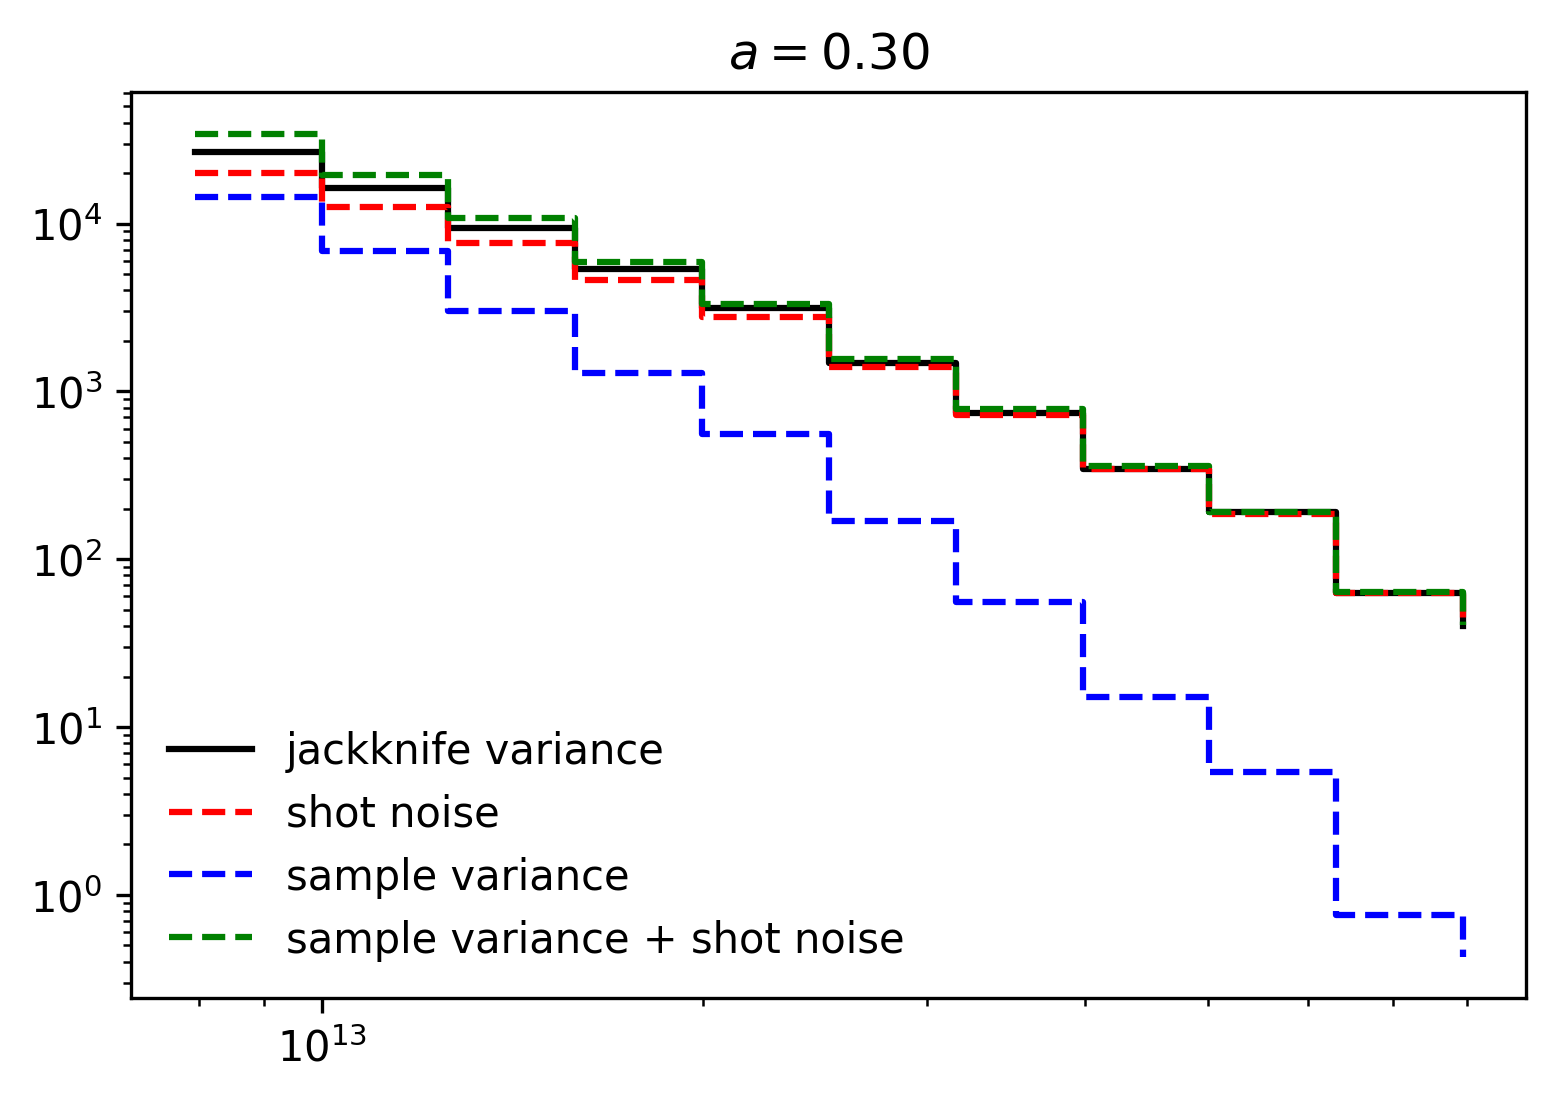

100%|██████████| 500/500 [18:33<00:00,  2.23s/it]


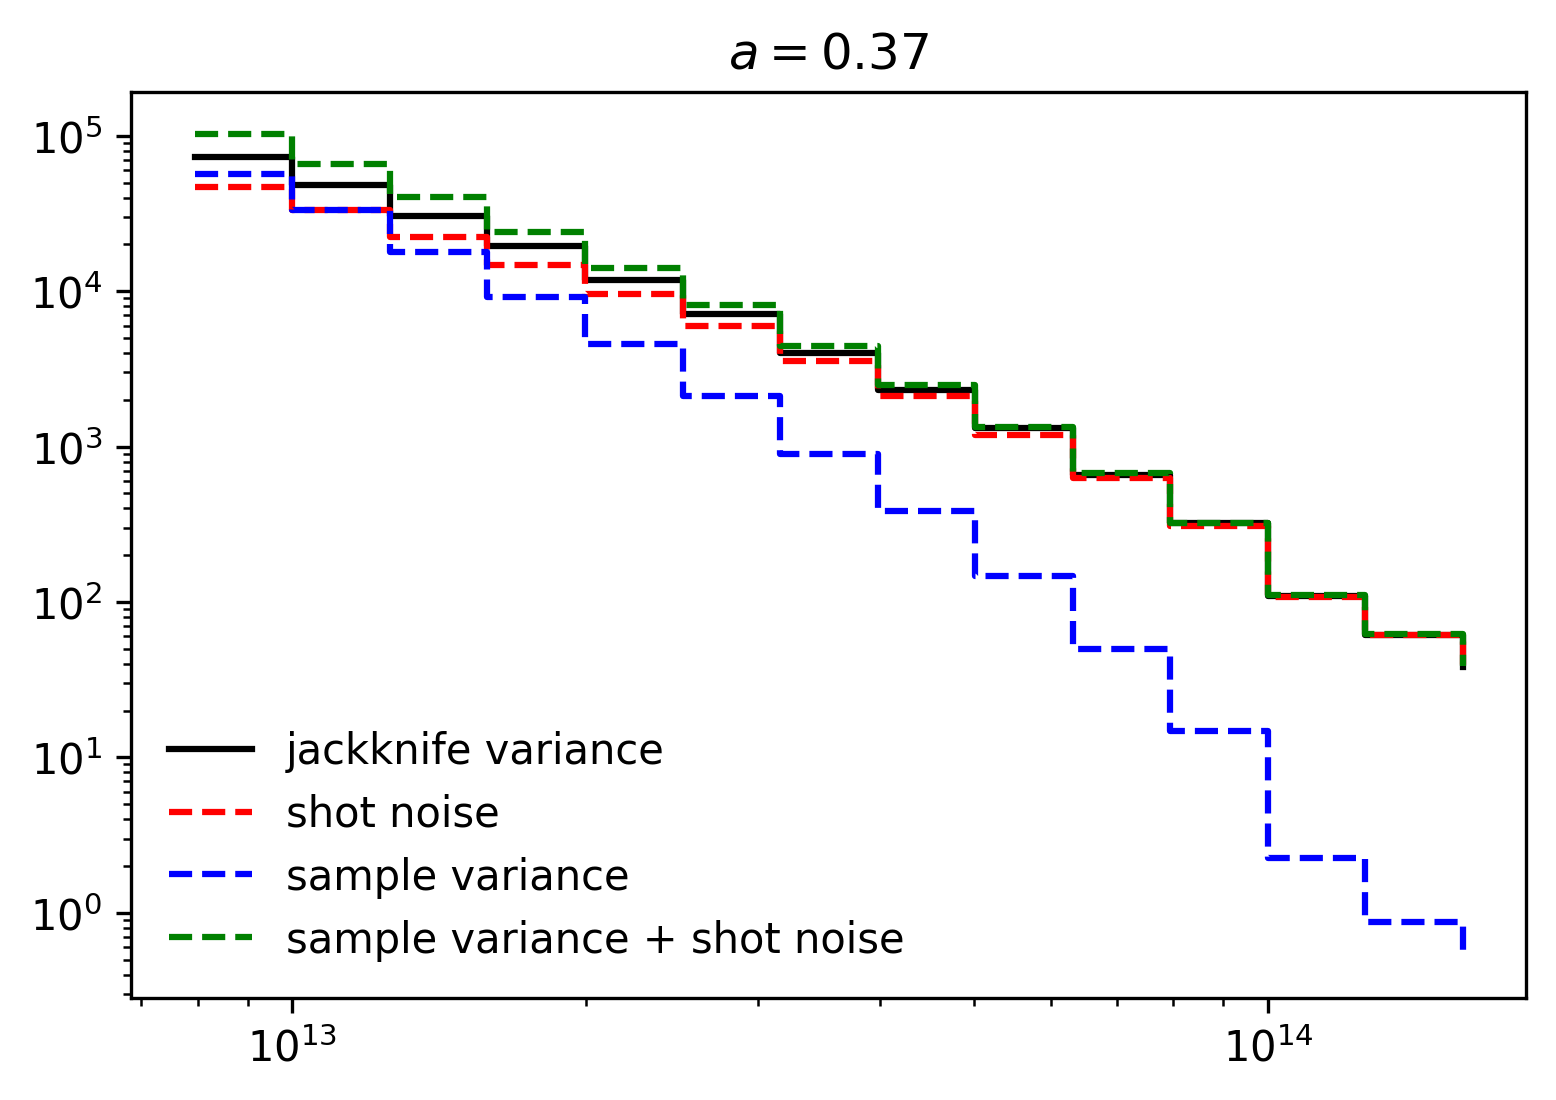

100%|██████████| 500/500 [18:34<00:00,  2.23s/it]


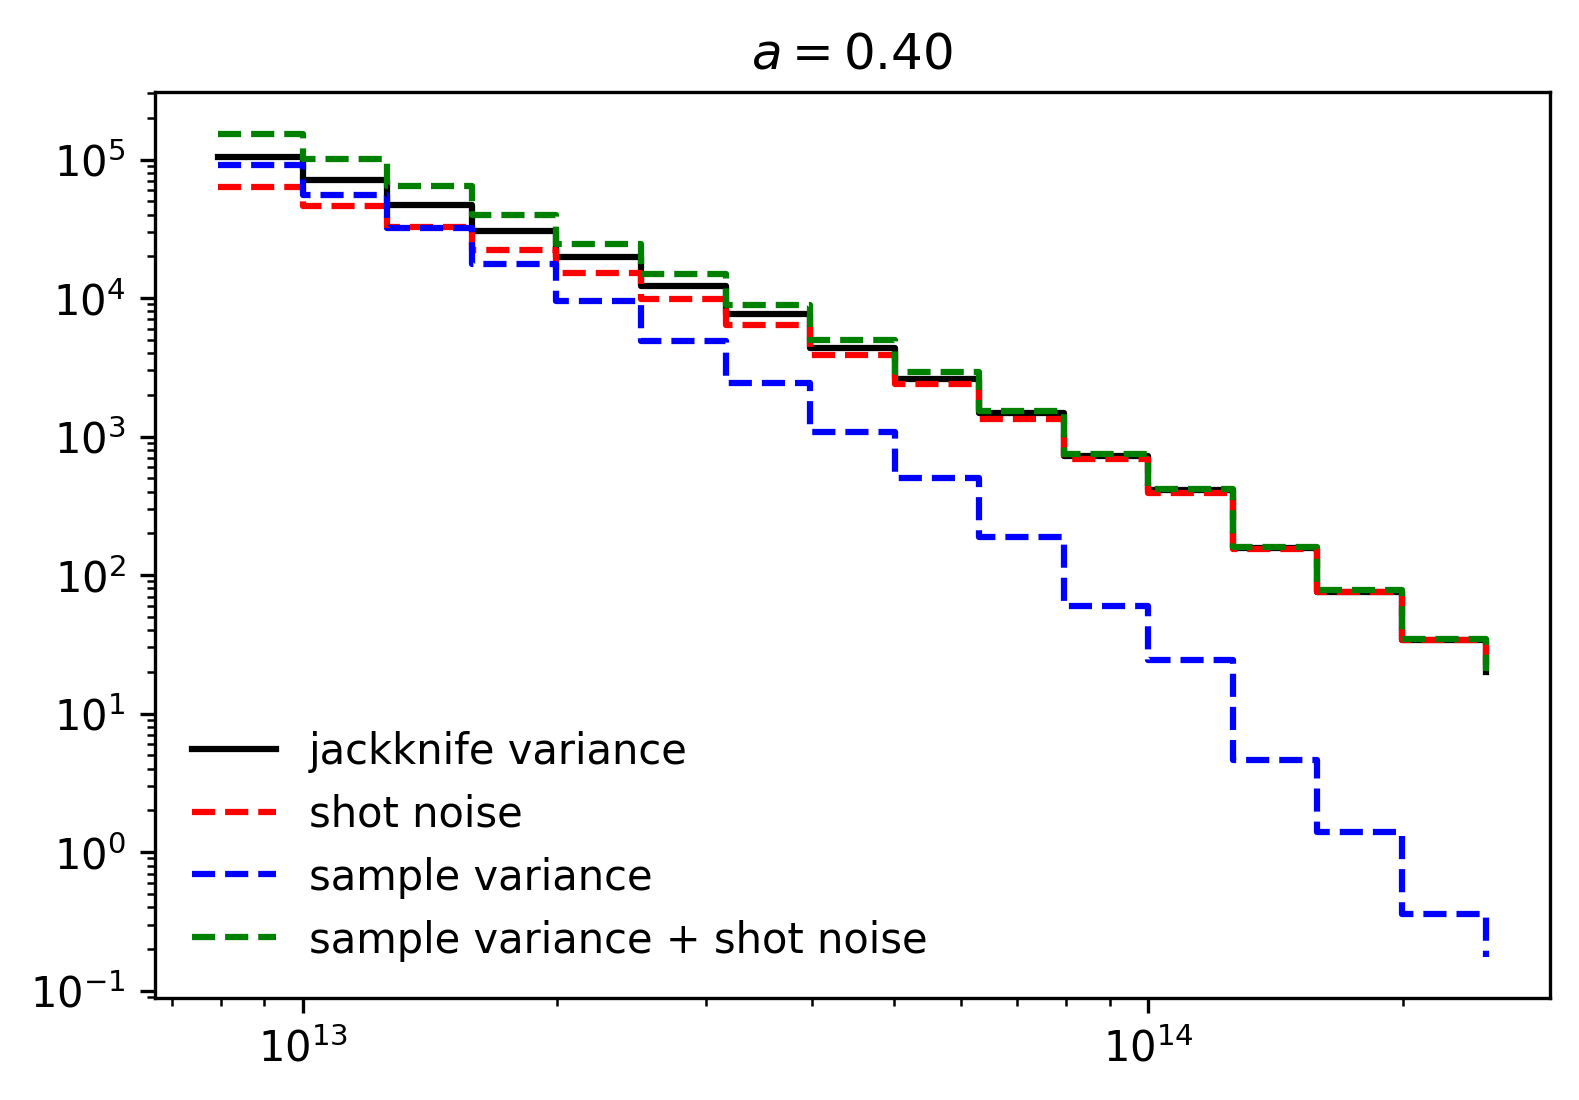

100%|██████████| 500/500 [18:32<00:00,  2.23s/it]


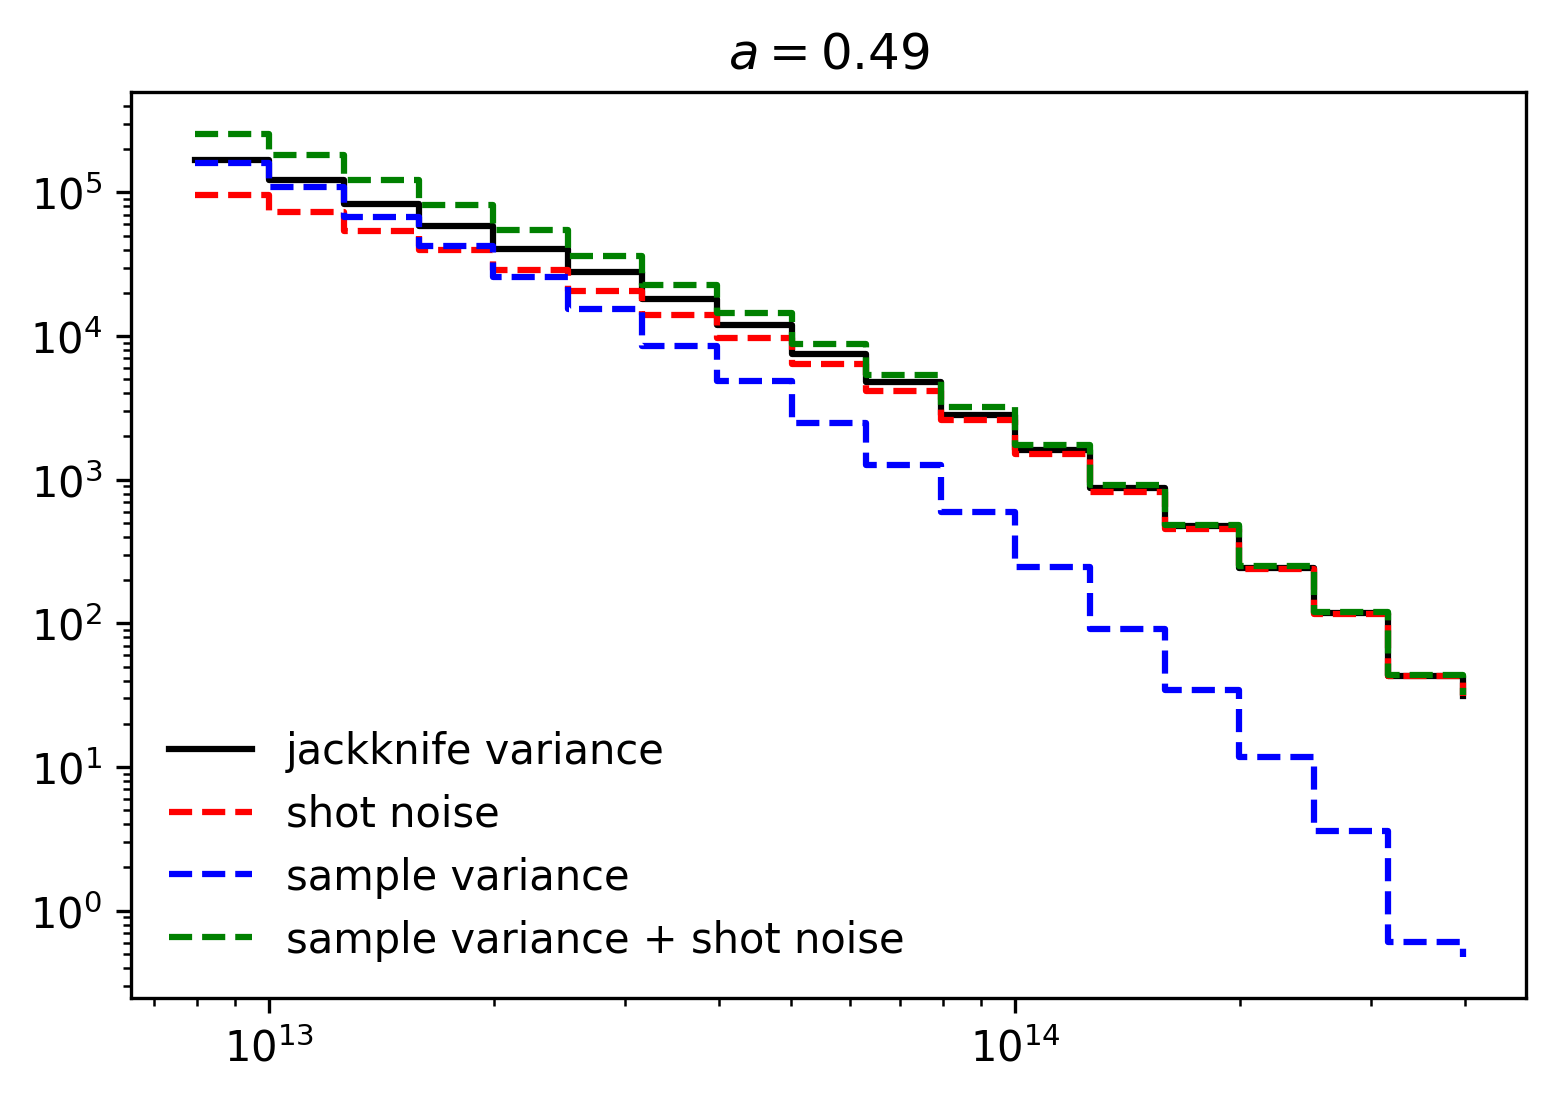

100%|██████████| 500/500 [18:34<00:00,  2.23s/it]


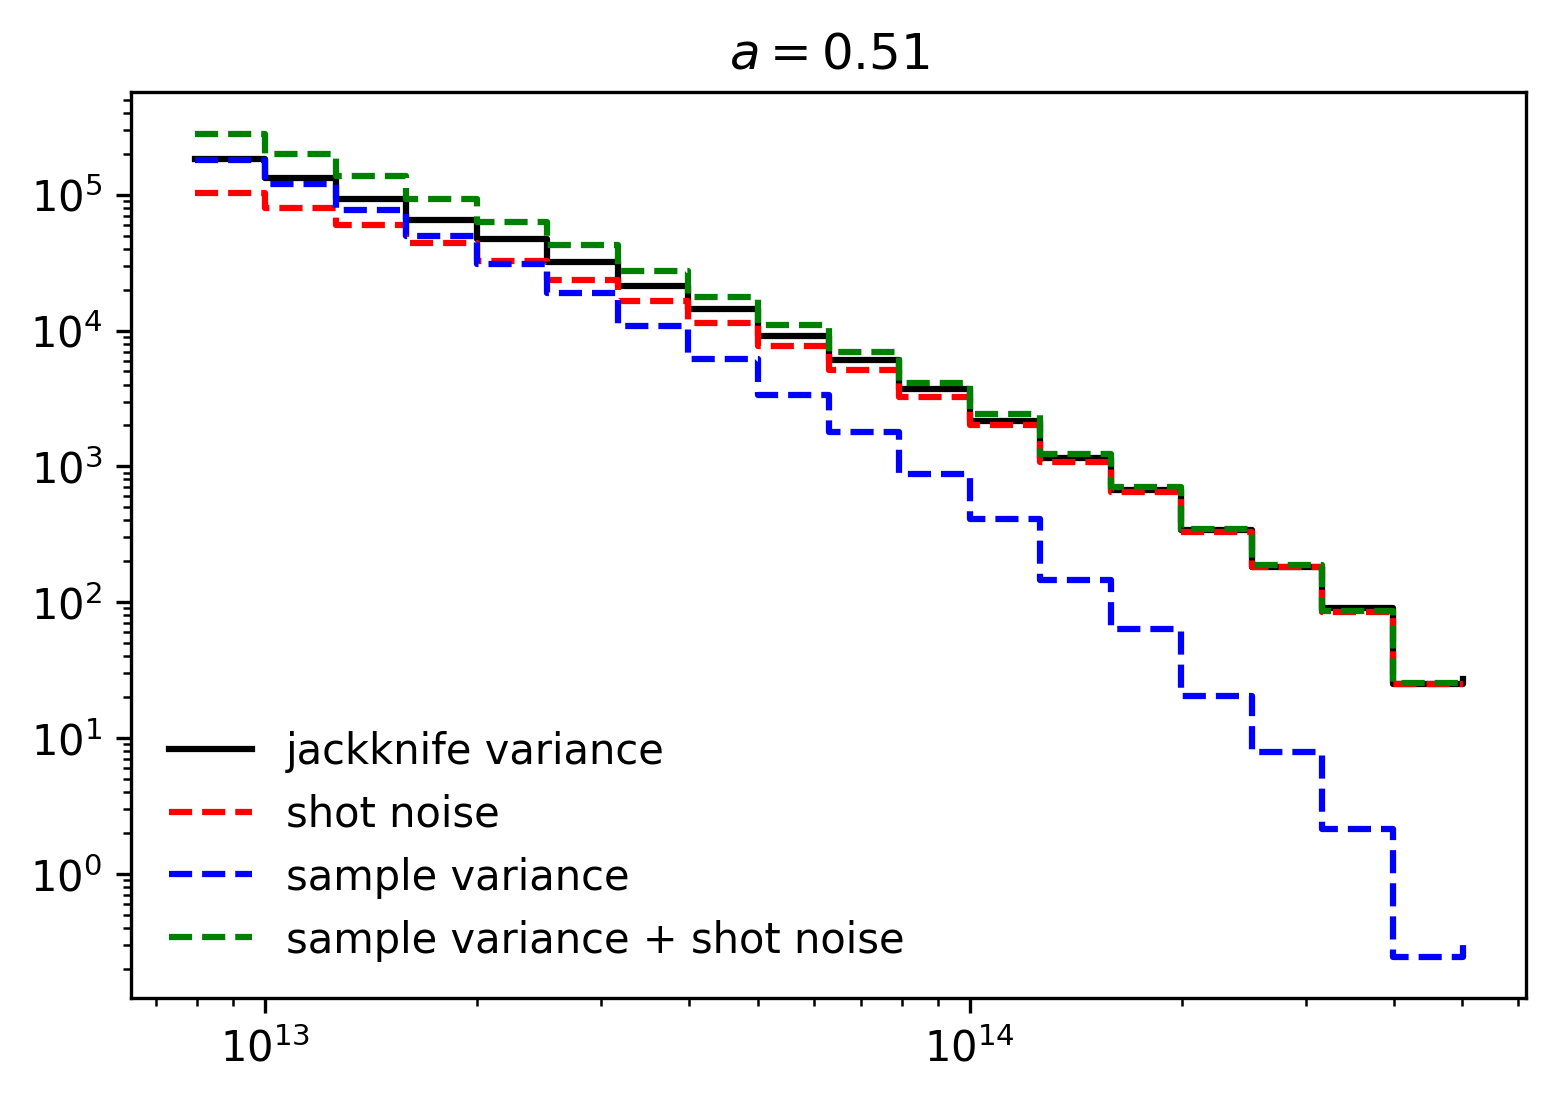

100%|██████████| 500/500 [18:32<00:00,  2.23s/it]


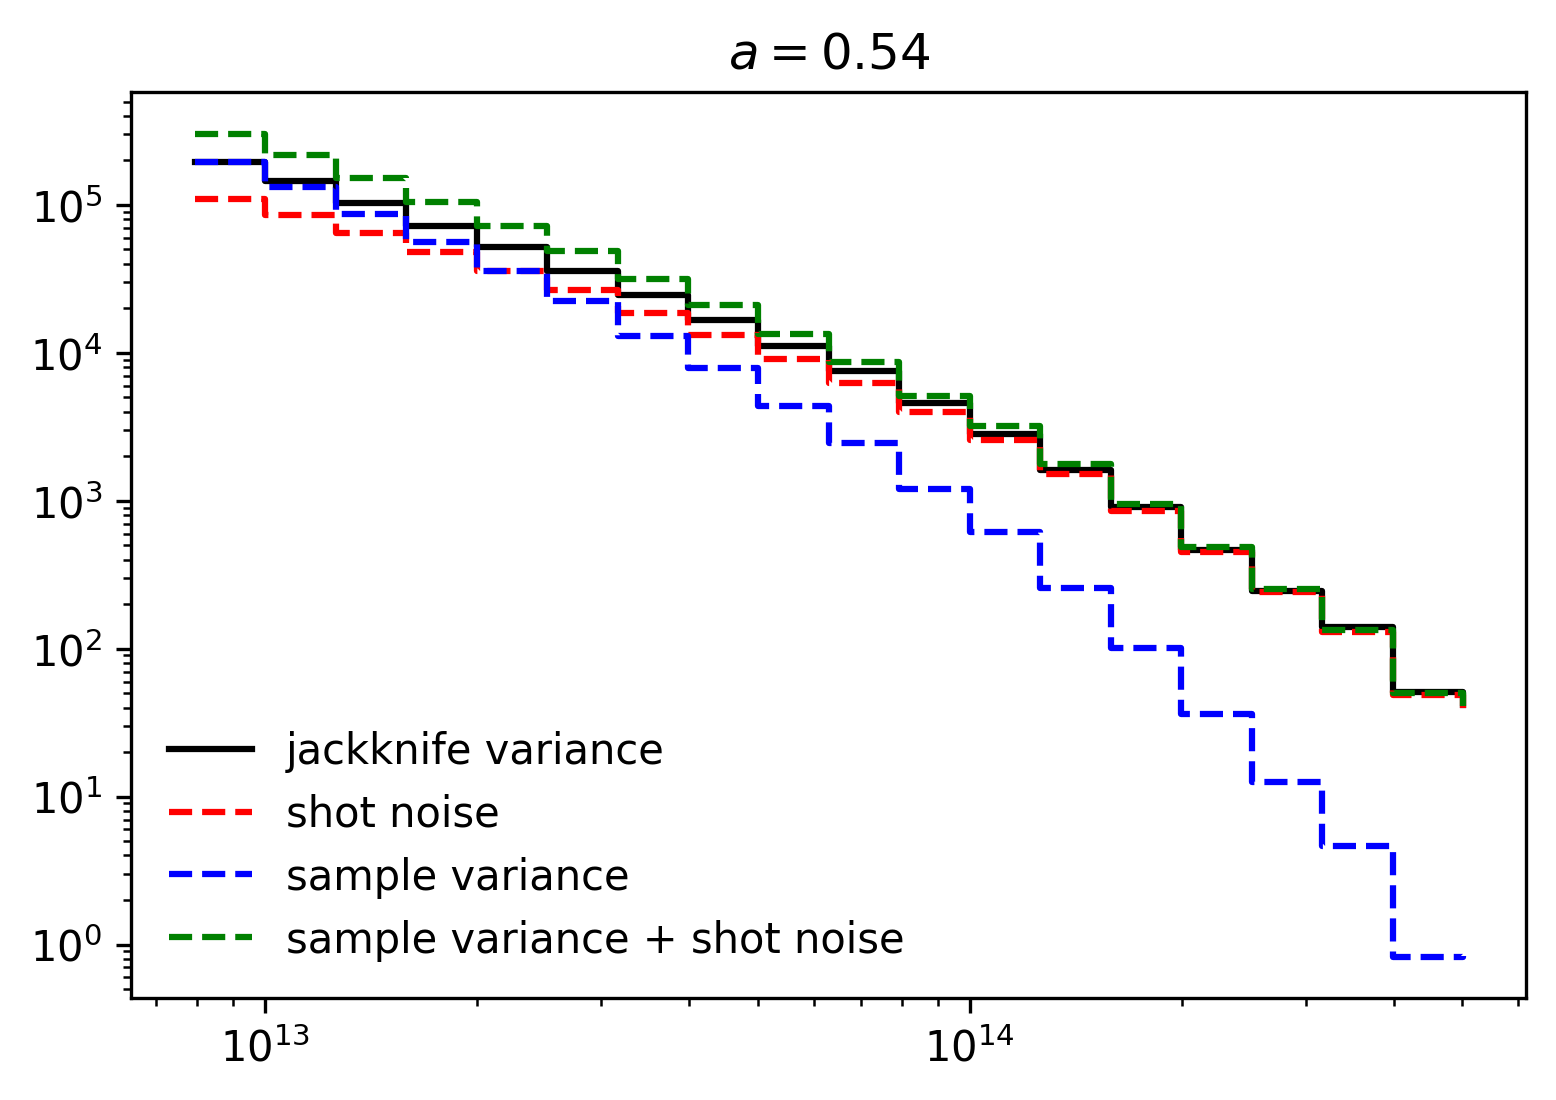

100%|██████████| 500/500 [18:35<00:00,  2.23s/it]


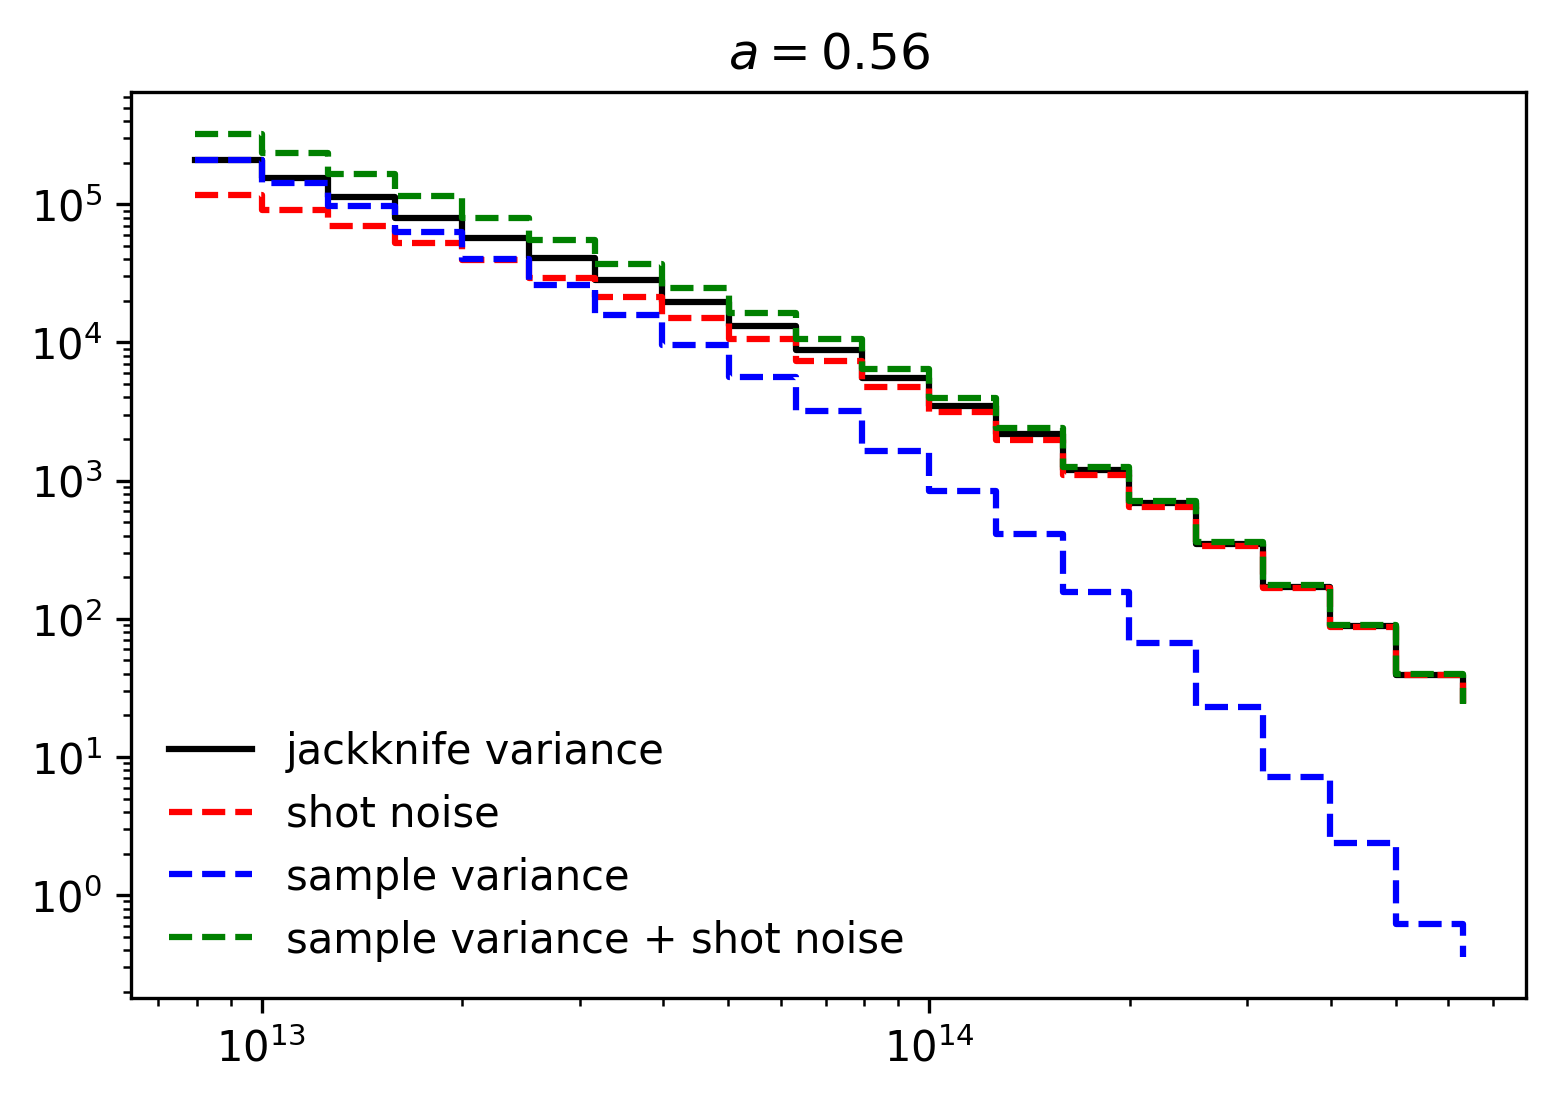

100%|██████████| 500/500 [18:33<00:00,  2.23s/it]


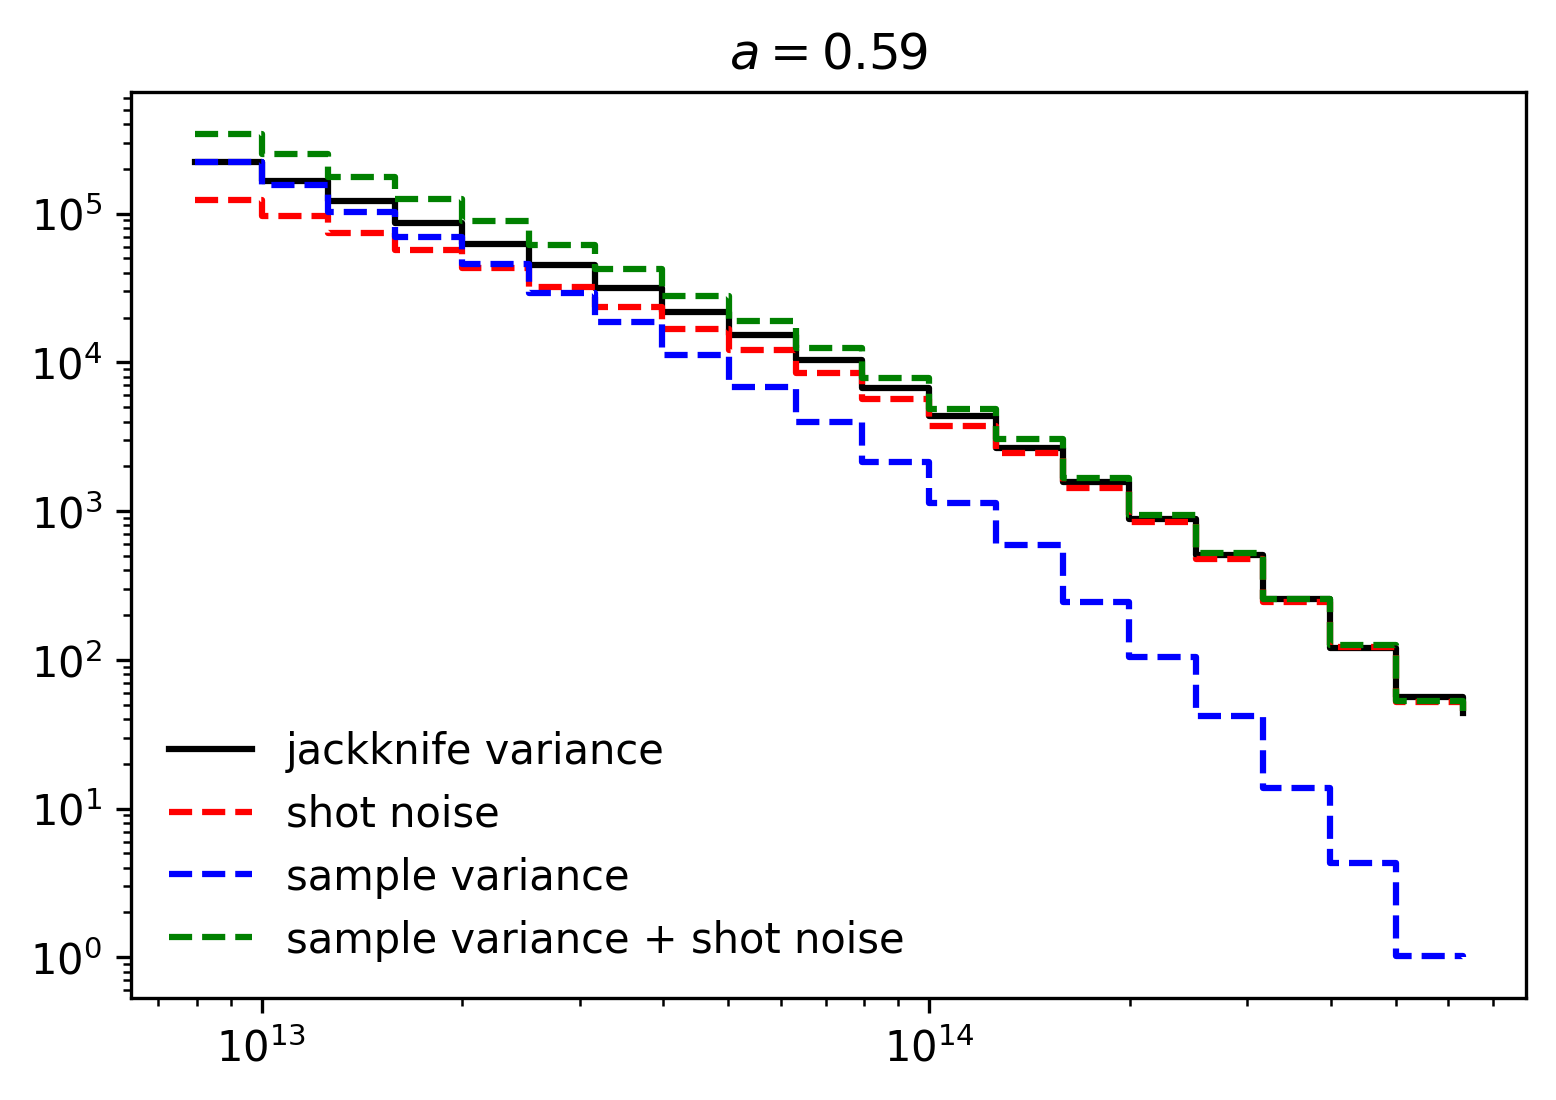

100%|██████████| 500/500 [18:31<00:00,  2.22s/it]


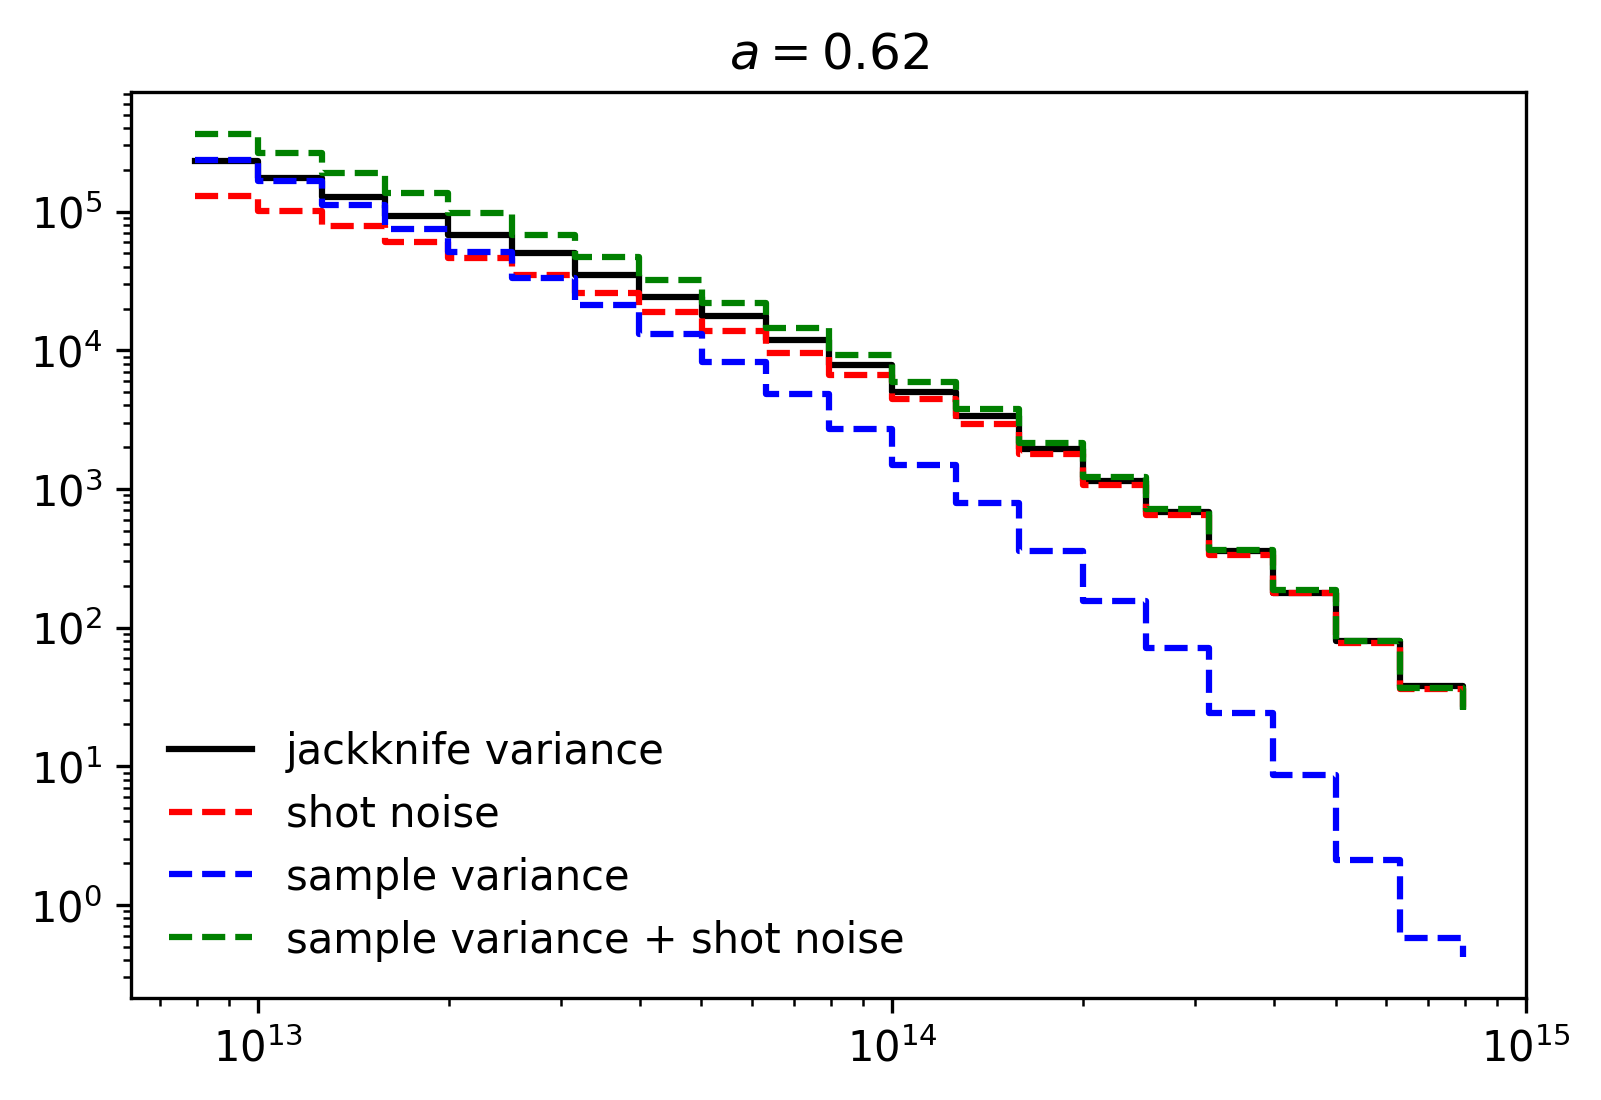

100%|██████████| 500/500 [18:44<00:00,  2.25s/it]


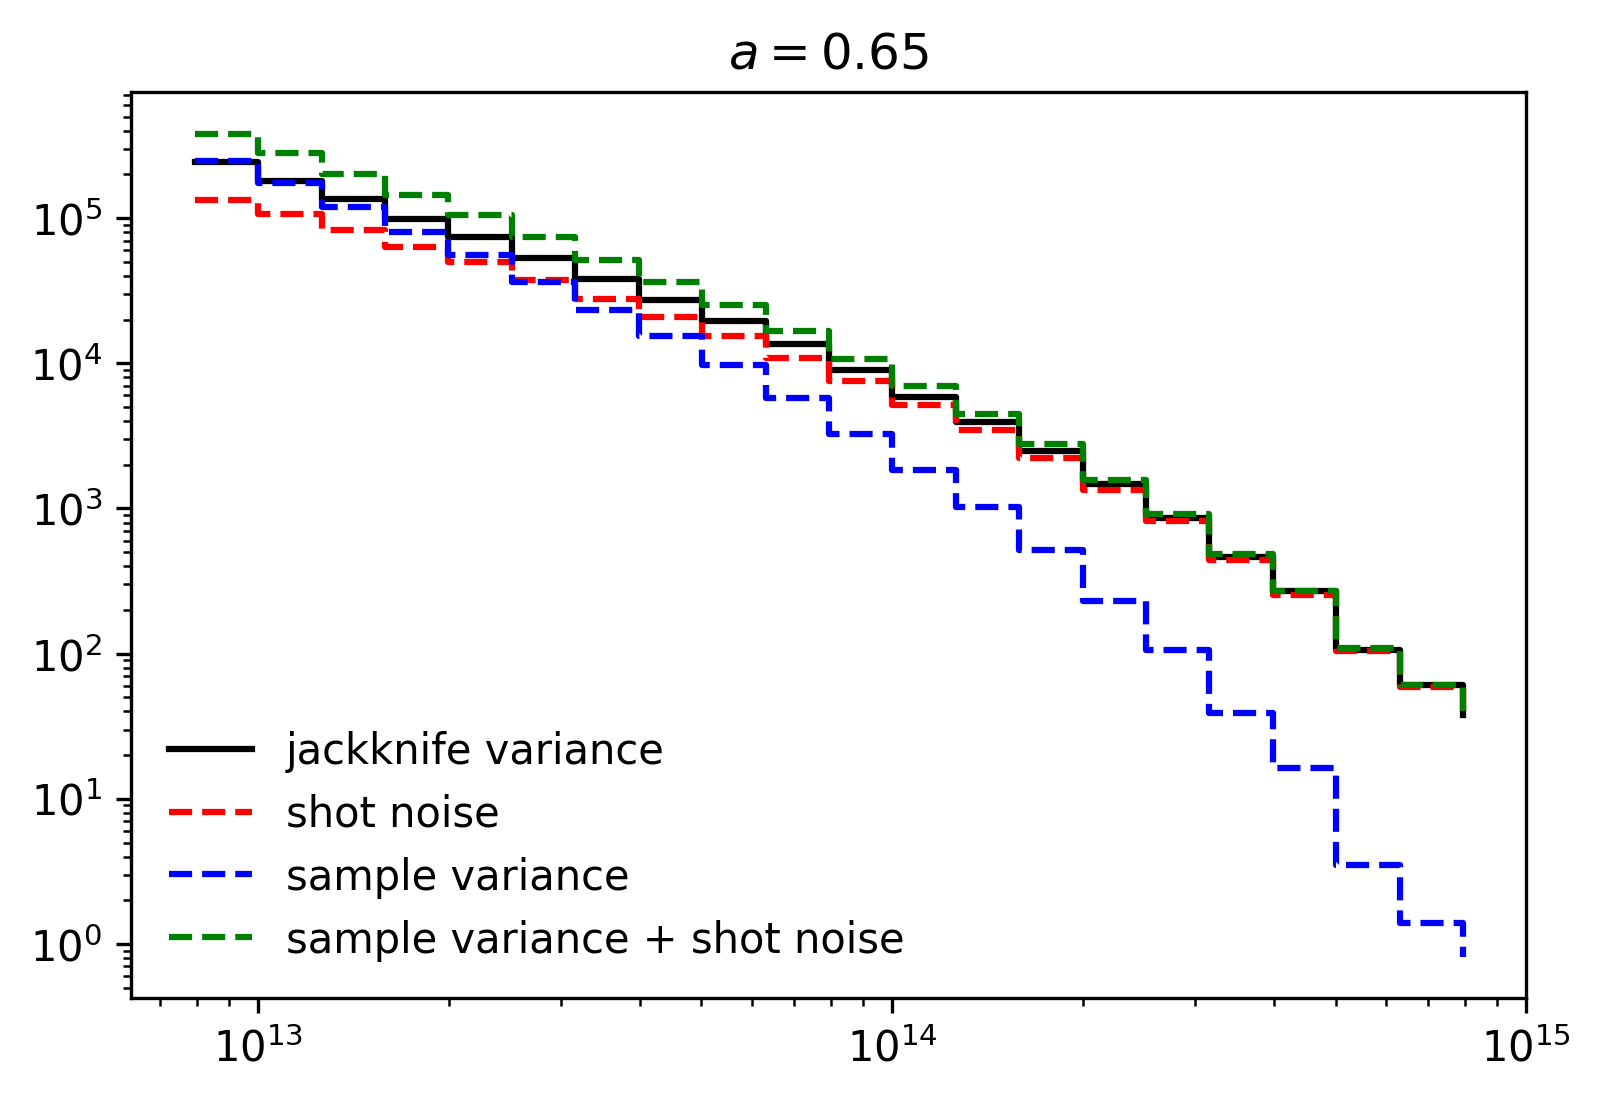

100%|██████████| 500/500 [18:31<00:00,  2.22s/it]


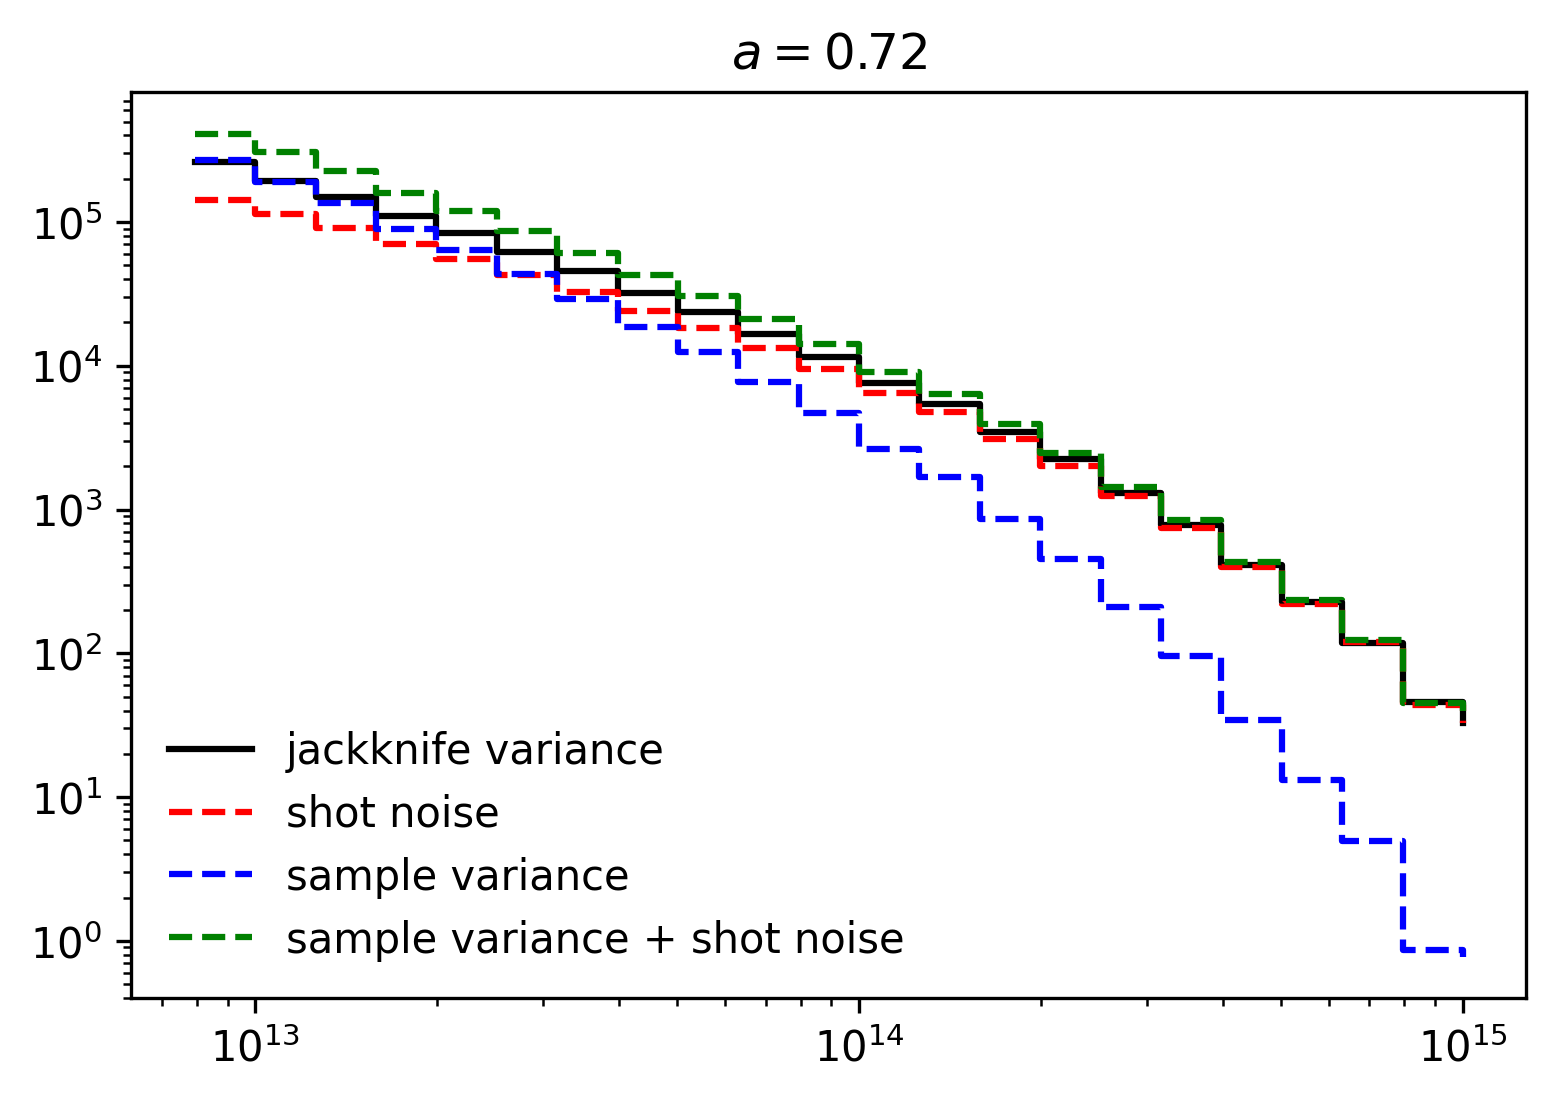

100%|██████████| 500/500 [18:36<00:00,  2.23s/it]


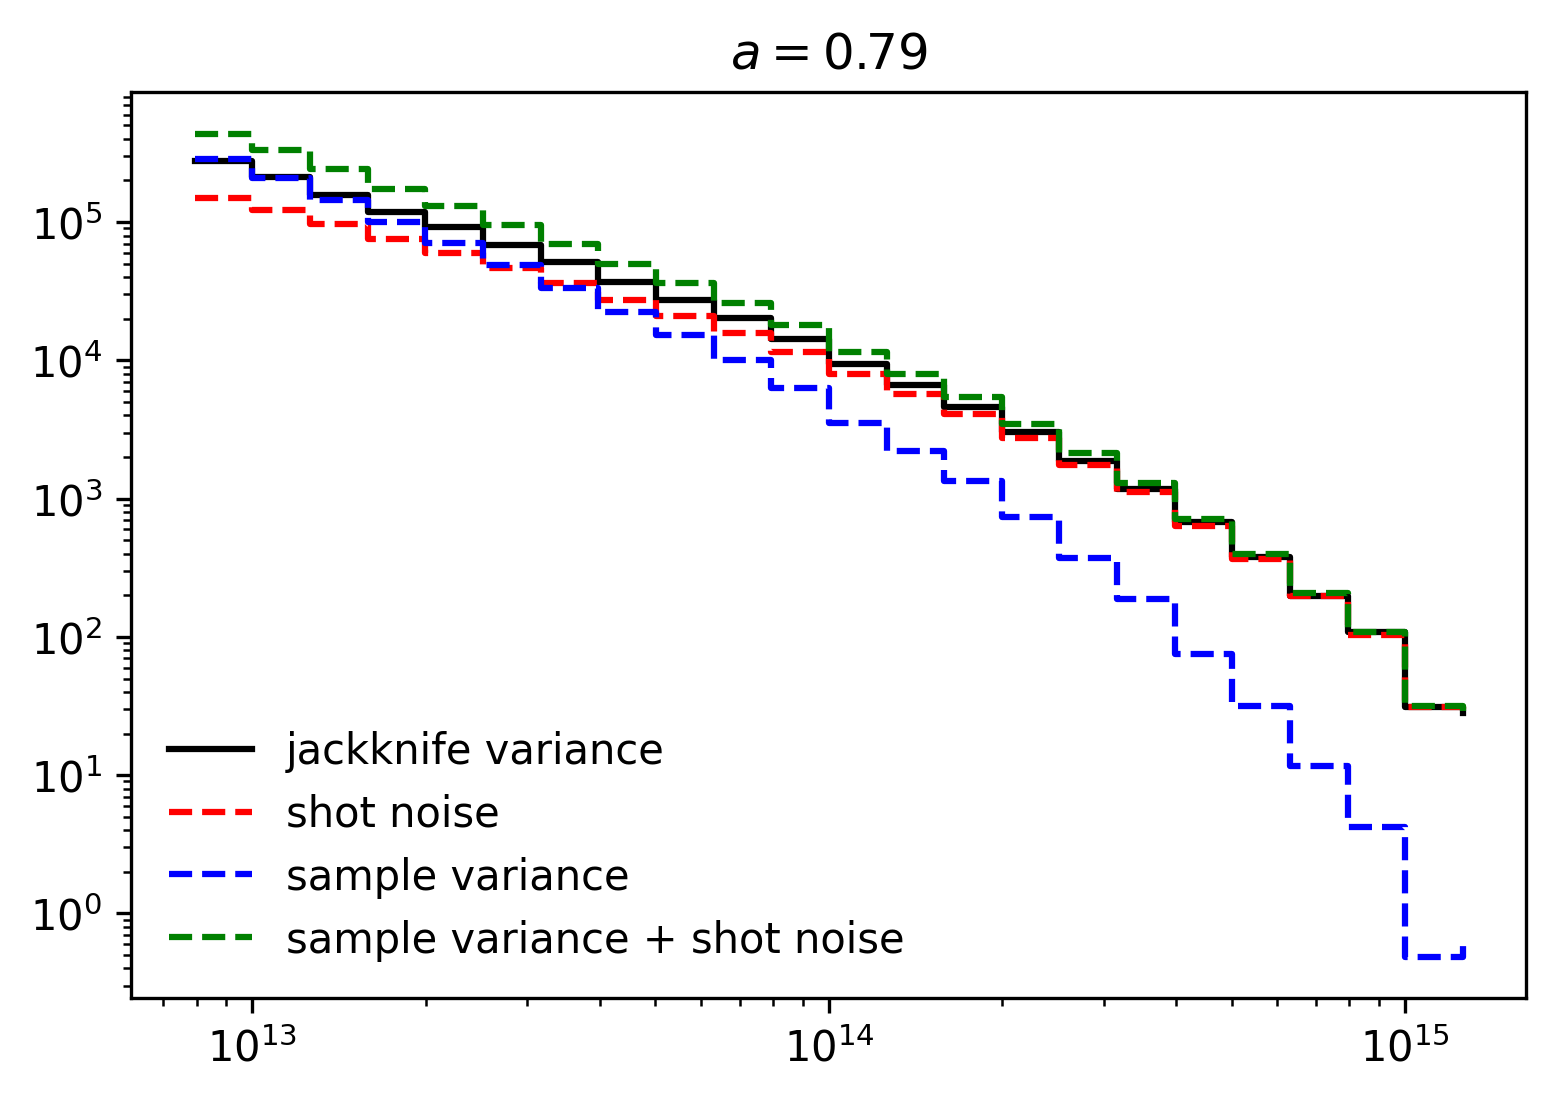

100%|██████████| 500/500 [18:33<00:00,  2.23s/it]


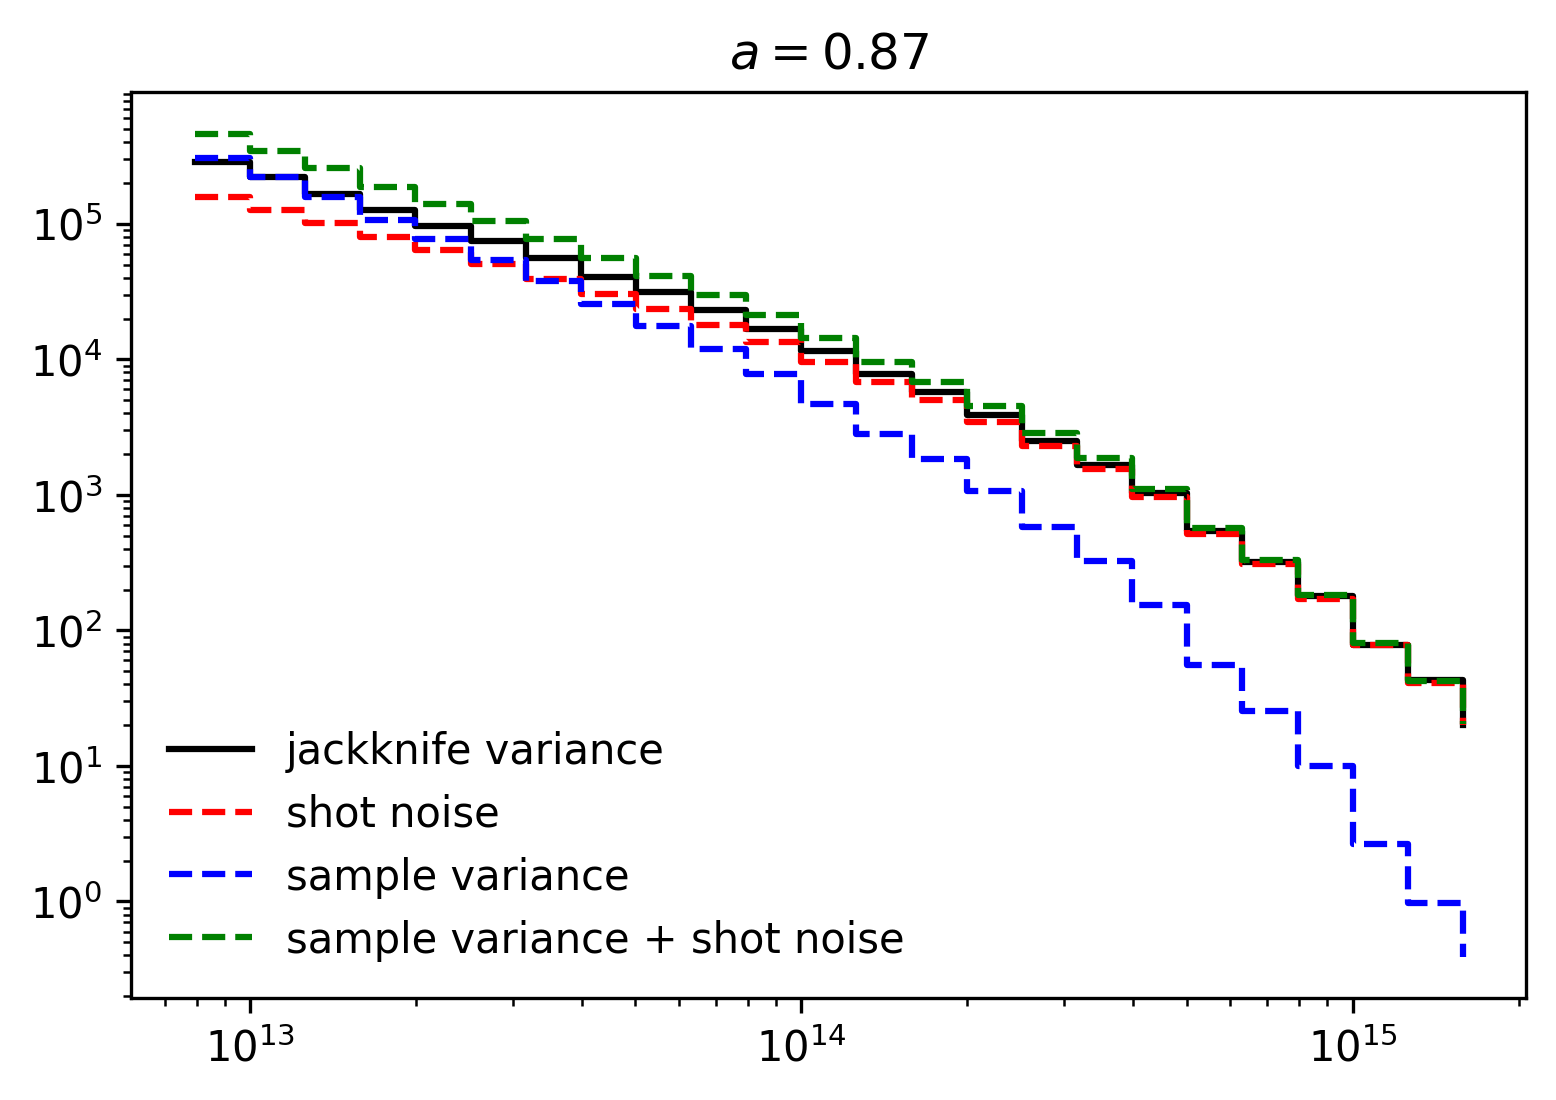

100%|██████████| 500/500 [18:51<00:00,  2.26s/it]


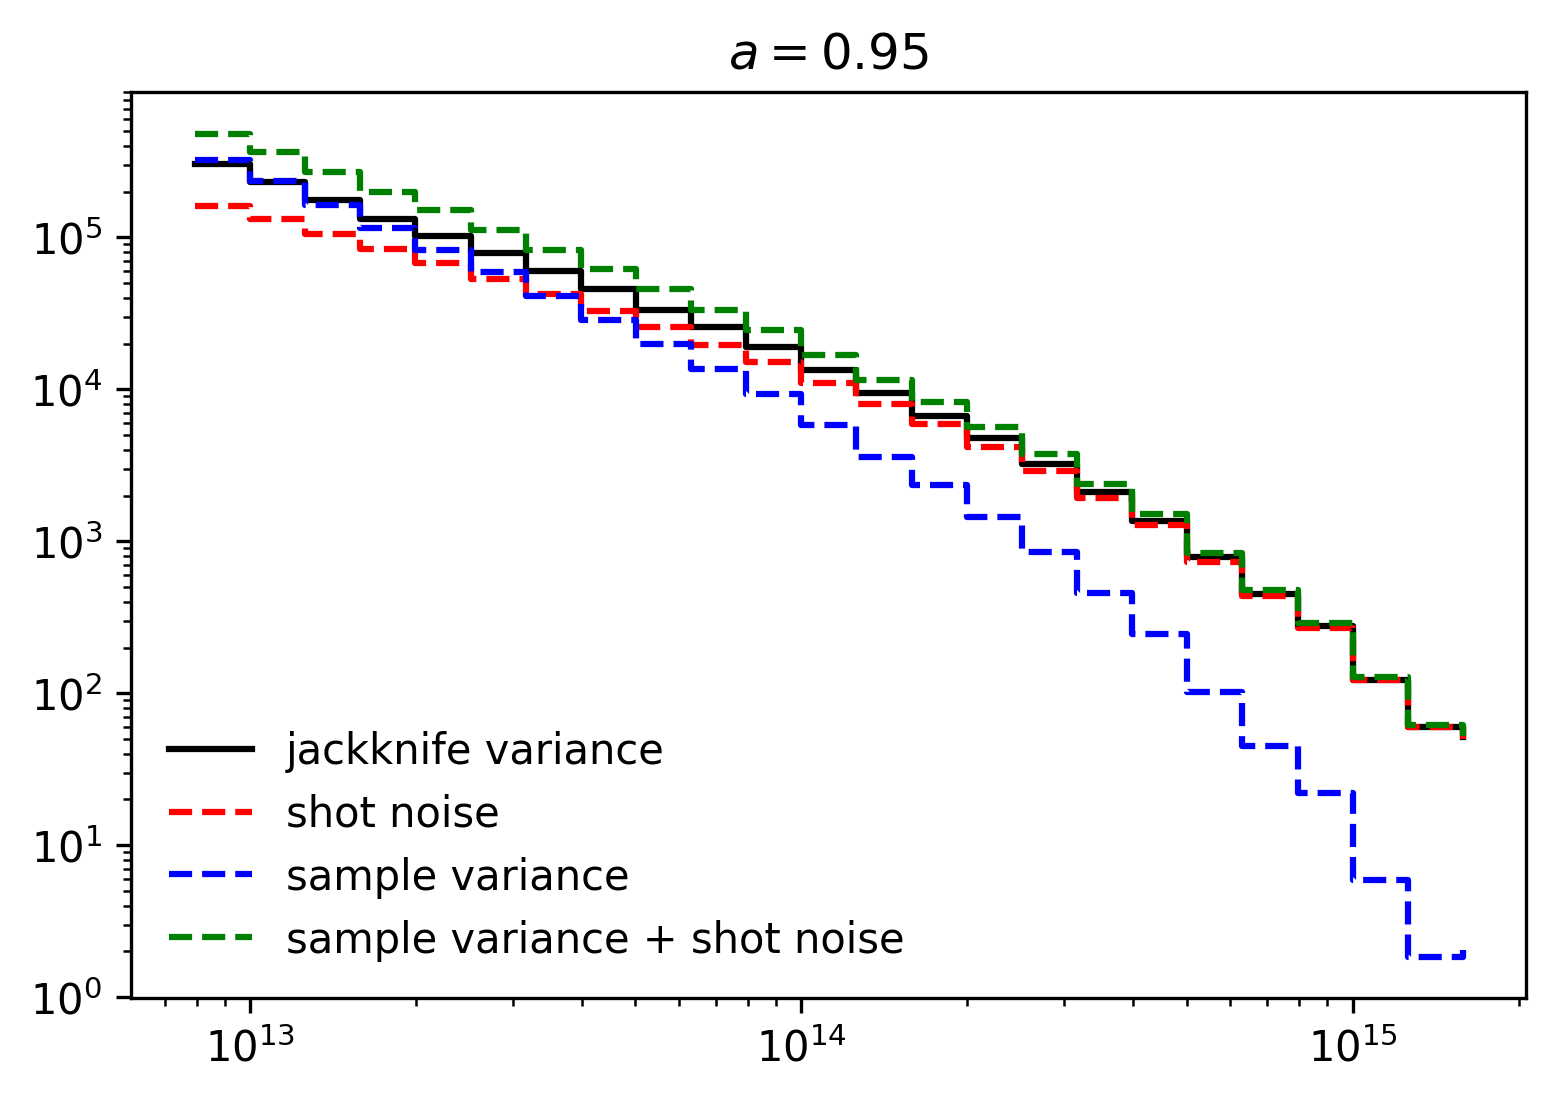

100%|██████████| 500/500 [17:57<00:00,  2.16s/it]


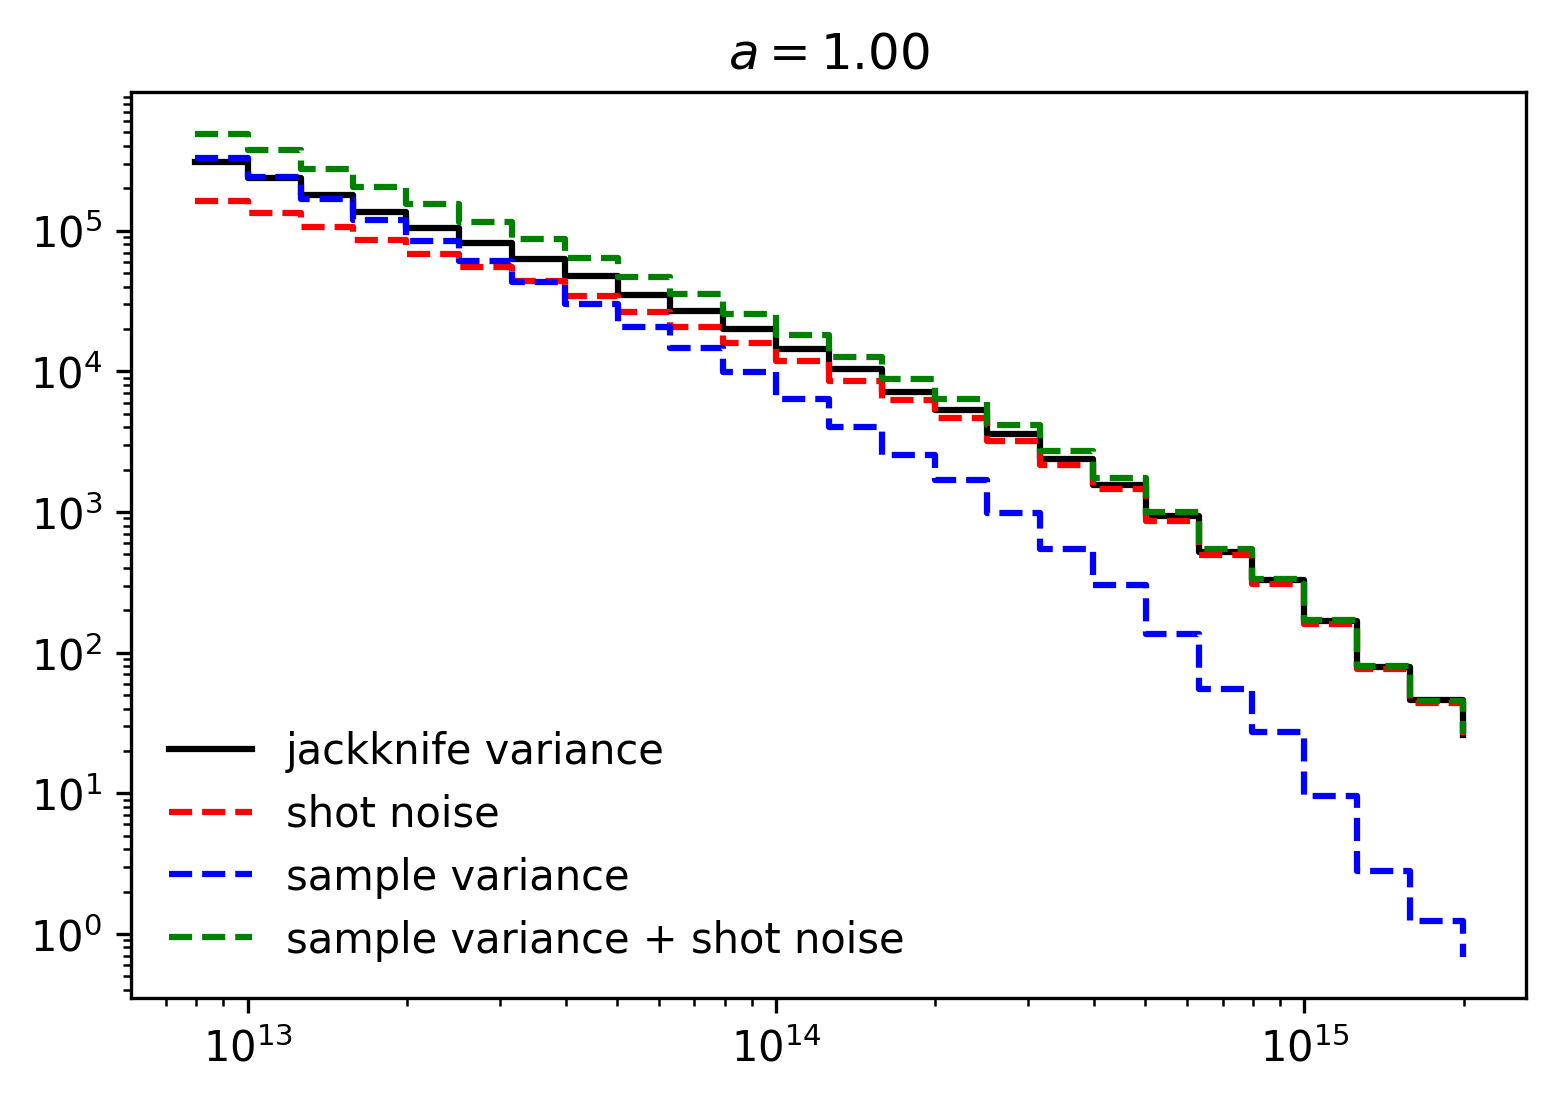

In [5]:
for curr_a in a_vals:
    plot_data[curr_a] = get('Box_n50_0_1400', curr_a)

In [6]:
plt.show()

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

plt.rcParams['font.size'] = 11

In [7]:
# fig = plt.figure(figsize=(6,5.7), dpi = 300)


# meta_ax = fig.add_subplot(111, facecolor=None)    # The big subplot
# meta_ax.spines['top'].set_color('none')
# meta_ax.spines['bottom'].set_color('none')
# meta_ax.spines['left'].set_color('none')
# meta_ax.spines['right'].set_color('none')
# meta_ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
# meta_ax.set_ylabel(r'(Cluster Abundance Error)${}^2$'+'\n')
# meta_ax.set_xlabel(r'Mass $[h^{-1} M_\odot]$')

# ax0 = fig.add_subplot(3,5,1)
# axs_flattened = [fig.add_subplot(3,5,i+1, sharey=ax0) for i in range(1,15)]
# print(len(axs_flattened))
# axs_flattened = [ax0] + axs_flattened
# print(len(axs_flattened))

# for curr_a, ax in zip(plot_data, axs_flattened):
#     tmp_data = plot_data[curr_a]
#     curr_bin_edges = tmp_data[0]
#     curr_var = np.diag(jackknife[curr_a][1])
#     curr_N = tmp_data[1][0]
#     sample_variance = tmp_data[1][1]
#     ax.step(curr_bin_edges, curr_var,
#              where='post', label=r'jackknife variance', c='k', ls='-')

#     ax.step(curr_bin_edges, curr_N,
#              where='post', label=r'shot noise', c='r', ls='--')
#     ax.step(curr_bin_edges, (sample_variance),
#              where='post', label=r'sample variance', c='b', ls='--')
#     ax.text(.02, .02,
#             s= '$z=%.2f$'%(1/curr_a - 1),
#             transform=ax.transAxes,
#             horizontalalignment='left',
#             verticalalignment='bottom',
#             c='black',
#            fontsize=11)
#     ax.set_xscale('log')
#     ax.set_yscale('log')
# #     ax.set_yticks([])
    
    
    
    



# fig.tight_layout()





In [8]:
import matplotlib as mpl
import matplotlib.colors as mcolors
rainbow = mpl.colormaps['rainbow'].resampled(len(a_vals))
rainbow_list = [mcolors.rgb2hex(rainbow(i)) for i in range(rainbow.N)]
rainbow_list = rainbow_list[::-1]

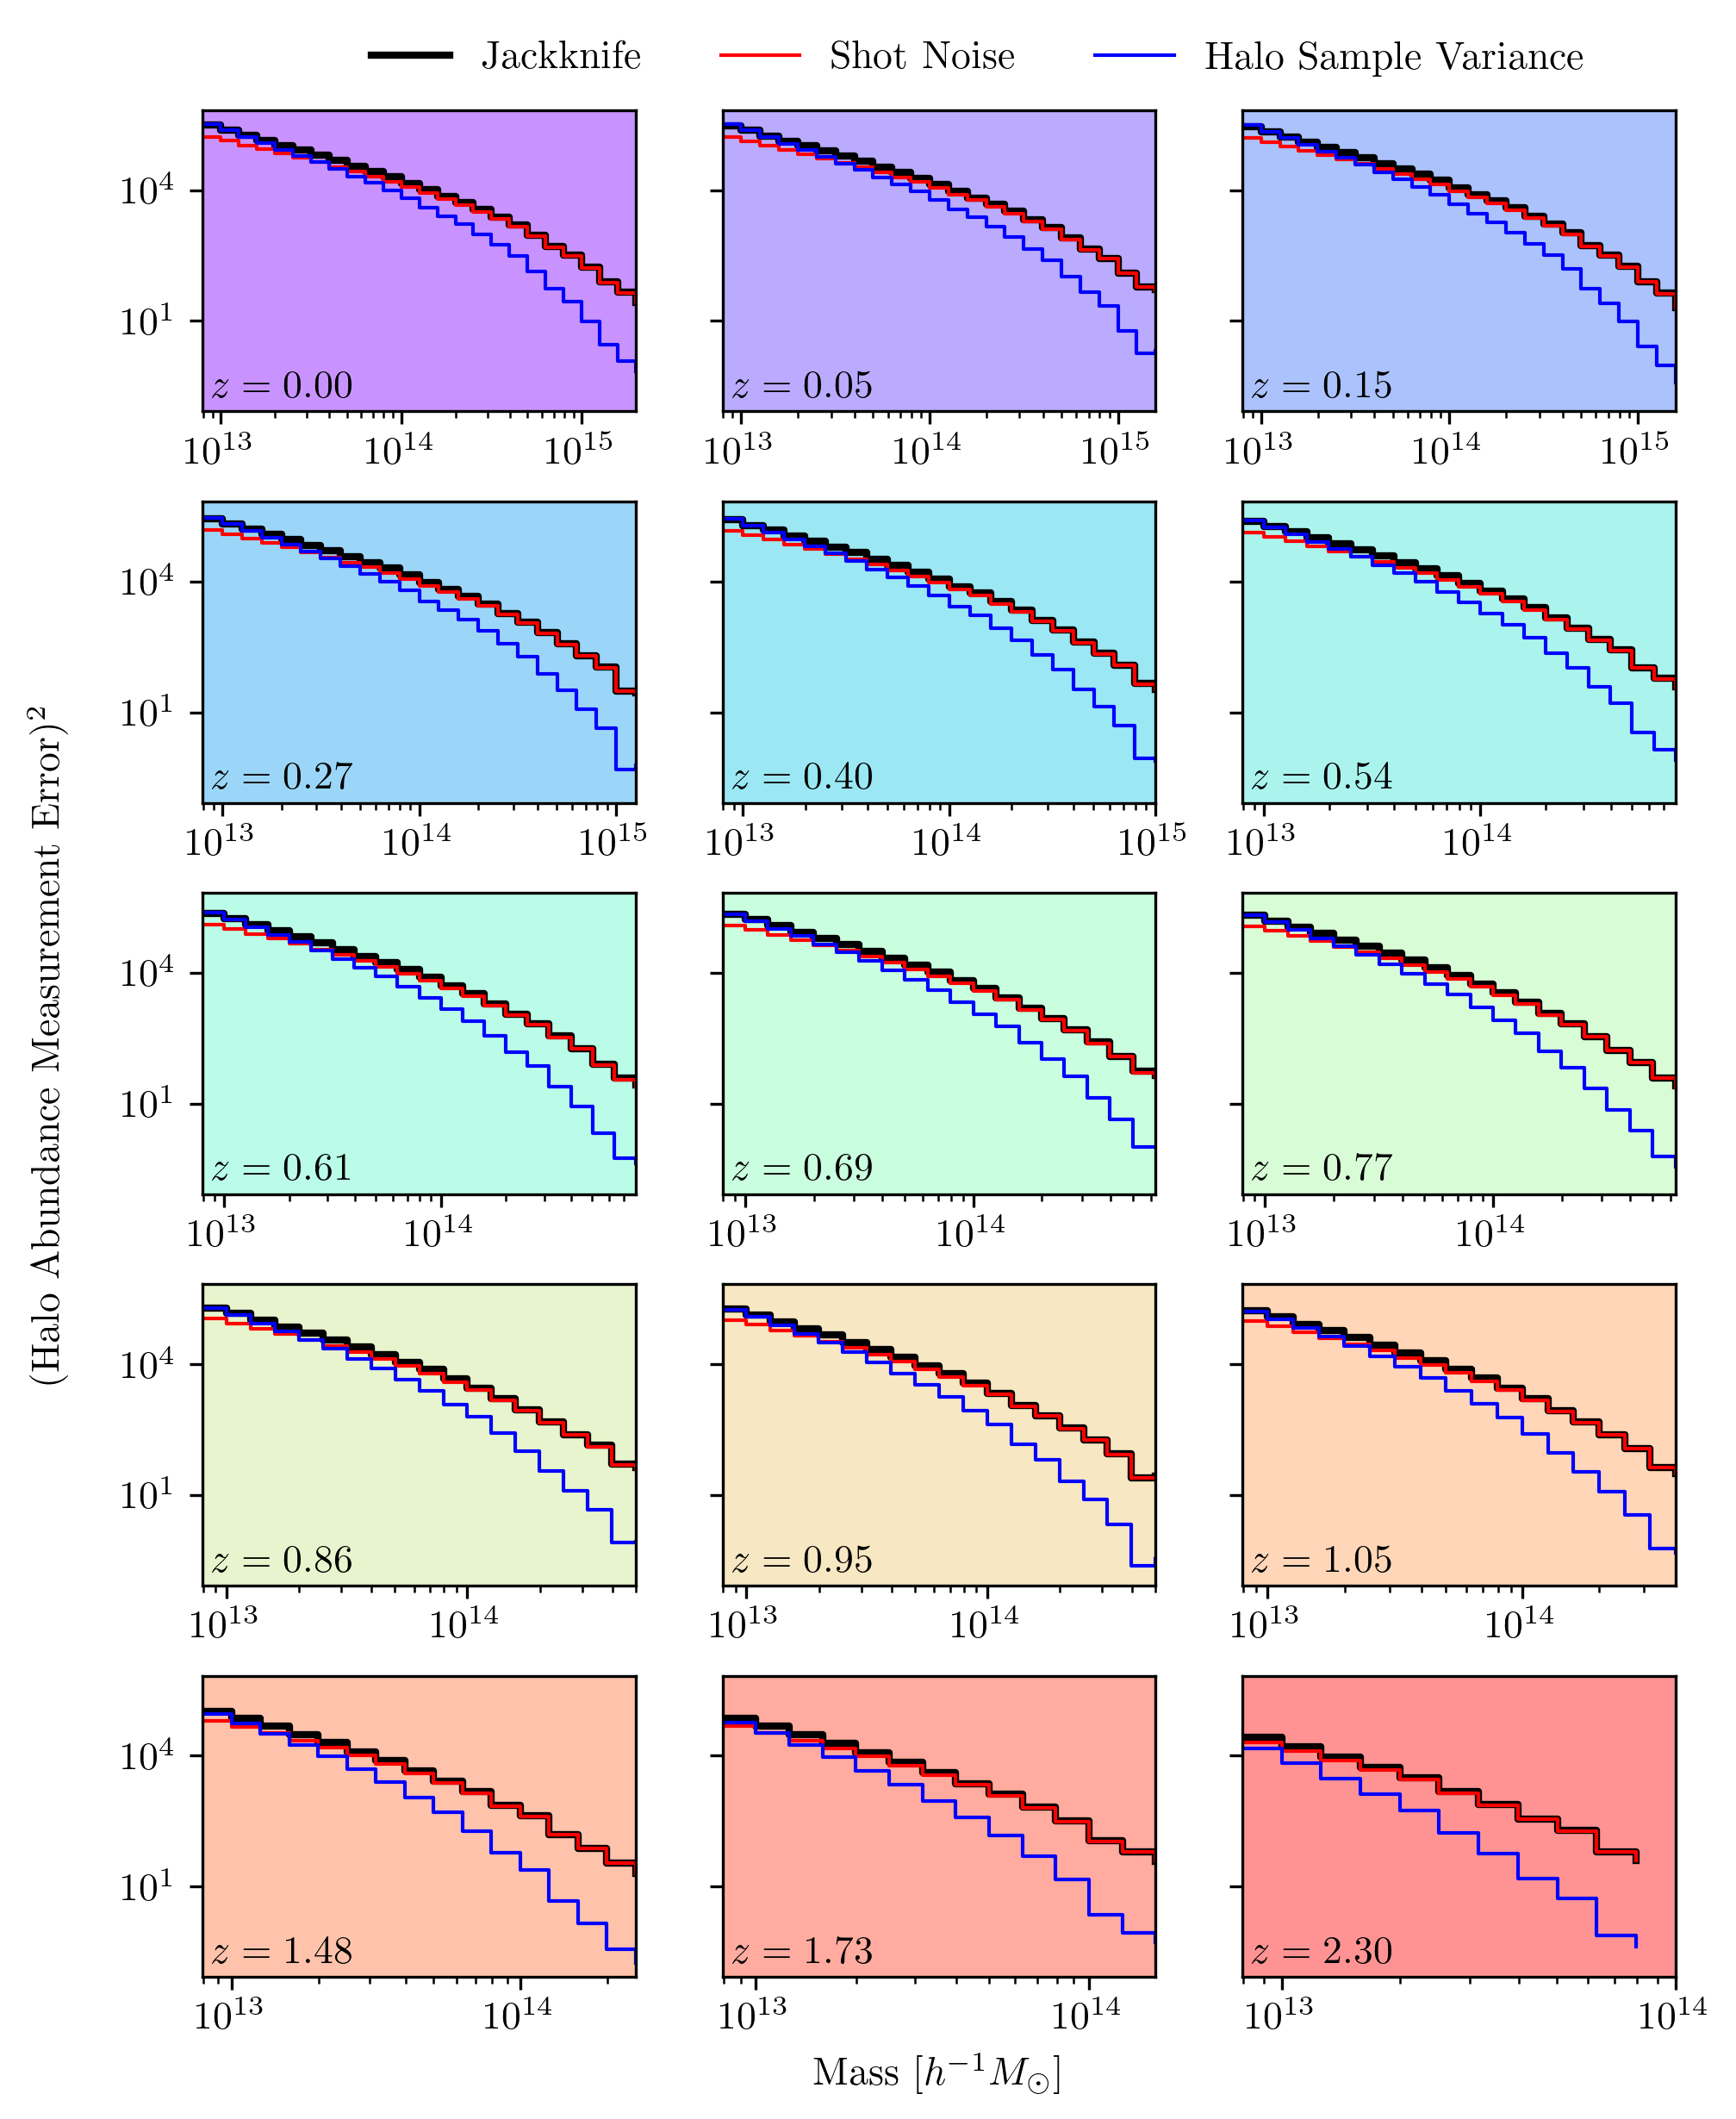

In [14]:

fig, axs = plt.subplots(figsize=(6,8), dpi = 300,
                       nrows = 5, ncols = 3, sharey=True)
axs_flattened = axs.flatten()
axs_flattened = axs_flattened[::-1]
color_idx = 0
for curr_a, ax in zip(plot_data, axs_flattened):
    tmp_data = plot_data[curr_a]
    curr_bin_edges = tmp_data[0]
    curr_var = np.diag(jackknife[curr_a][1])
    curr_N = tmp_data[1][0]
    sample_variance = tmp_data[1][1]
    ax.step(curr_bin_edges, curr_var,
             where='post', label=r'Jackknife', c='k', ls='-', lw=2)

    ax.step(curr_bin_edges, curr_N,
             where='post', label=r'Shot Noise', c='r', ls='-', lw=1)
    ax.step(curr_bin_edges, (sample_variance),
             where='post', label=r'Halo Sample Variance', c='b', ls='-', lw=1,)

#     ax.step(curr_bin_edges, (sample_variance),
#              where='post', label=r'Sample Variance', c='#00ffe2', ls='--', lw=1,)
    ax.text(.02, .02,
            s= '$z=%.2f$'%(1/curr_a - 1),
            transform=ax.transAxes,
            horizontalalignment='left',
            verticalalignment='bottom',
            c='black',
           fontsize=11)
    ax.set_xscale('log')
    ax.set_yscale('log')    
    ax.set_xlim(np.min(curr_bin_edges), np.max(curr_bin_edges))
    ax.patch.set_facecolor(rainbow_list[color_idx])
    ax.patch.set_alpha(0.42)
    color_idx += 1
    
axs_flattened[0].set_xticks([1e13, 1e14])

axs[2][0].set_ylabel(r'(Halo Abundance Measurement Error)${}^2$'+'\n')
axs[-1][1].set_xlabel(r'Mass $[h^{-1} M_\odot]$')
# axs_flattened[0].legend(frameon = False)

fig.tight_layout()
fig.subplots_adjust(left=0.00, wspace=0.2, hspace = 0.3)

handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.5, 1.03), loc='upper center', ncol=3, frameon = False)
plt.savefig('analytical_hsv_sn_vs_jackknife.pdf', bbox_inches='tight')